In [2]:
# srgan 가상환경으로 돌림(tf=2.8, tf_gpu=2.8, keras=2.8)

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from data_augmentation import *
from model import *
from data_download import *

from tensorflow import keras
from keras import layers


AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
epochs = 500

In [21]:
train_cache, val_cache = div2k_download()

### 데이터 증강(Flip, Rotate 등)

In [22]:
train_ds = prepare_dataset(train_cache, training=True)
val_ds = prepare_dataset(val_cache, training=False)

### 이미지 확인

In [49]:
lowres, highres = next(iter(train_ds))

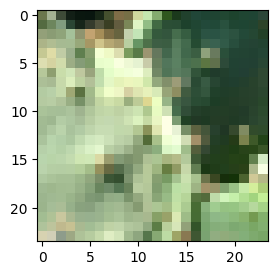

In [50]:
plt.figure(figsize=(3, 3))
plt.imshow(lowres[1]) # 저해상도 데이터셋

In [53]:
# lowres 배열에서 NumPy 배열로 데이터를 추출
lowres_numpy = lowres.numpy()

plt.imsave('./test_image/test_image1_low.png',lowres_numpy[1])

TensorShape([96, 96, 3])

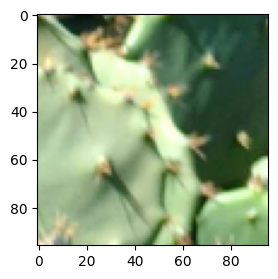

In [52]:
plt.figure(figsize=(3, 3))
plt.imshow(highres[1]) # 고해상도 데이터셋
highres[1].shape

In [54]:
# lowres 배열에서 NumPy 배열로 데이터를 추출
highres_numpy = highres.numpy()

plt.imsave('./test_image/test_image1_high.png',highres_numpy[1])

### 훈련


In [28]:
model = make_model(num_filters=64, num_of_residual_blocks=16)

In [29]:
import time

timestamp = time.strftime("%Y-%m-%d_%H-%M", time.localtime())

filename = './checkpoint/EDSR_epoch{}_{}.h5'.format(epochs,timestamp)

optim_edsr = keras.optimizers.Adam(
    learning_rate=keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[200000], values=[1e-4, 5e-5]
    )
)
# Compiling model with loss as mean absolute error(L1 Loss) and metric as psnr
model.compile(optimizer=optim_edsr, loss="mae", metrics=[PSNR])

callbacks = [ 
    # tensorboardm
    # tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True),
    
    ModelCheckpoint(filepath=filename,
                        monitor='val_loss', 
                        save_weights_only=False, 
                        verbose=1,  
                        save_best_only=True,  
                        mode='auto')  
                        ]

# Training for more epochs will improve results
model.fit(train_ds, epochs=epochs, steps_per_epoch=500, validation_data=val_ds, callbacks=callbacks)

Epoch 1/500
500/500 [==============================] - ETA: 0s - loss: 19.6152 - PSNR: 22.0846
Epoch 1: val_loss improved from inf to 11.29054, saving model to ./checkpoint\EDSR_epoch500_2024-05-14_19-00.h5
500/500 [==============================] - 17s 30ms/step - loss: 19.6152 - PSNR: 22.0846 - val_loss: 11.2905 - val_PSNR: 25.4699
Epoch 2/500
499/500 [============================>.] - ETA: 0s - loss: 10.0892 - PSNR: 26.7577
Epoch 2: val_loss improved from 11.29054 to 9.36767, saving model to ./checkpoint\EDSR_epoch500_2024-05-14_19-00.h5
500/500 [==============================] - 9s 19ms/step - loss: 10.0838 - PSNR: 26.7638 - val_loss: 9.3677 - val_PSNR: 27.1906
Epoch 3/500
499/500 [============================>.] - ETA: 0s - loss: 9.0996 - PSNR: 27.9001
Epoch 3: val_loss improved from 9.36767 to 8.26566, saving model to ./checkpoint\EDSR_epoch500_2024-05-14_19-00.h5
500/500 [==============================] - 9s 19ms/step - loss: 9.0947 - PSNR: 27.9083 - val_loss: 8.2657 - val_PSNR:

### Bicubic과 FSRCNN과 EDSR 비교

(24, 24, 3)

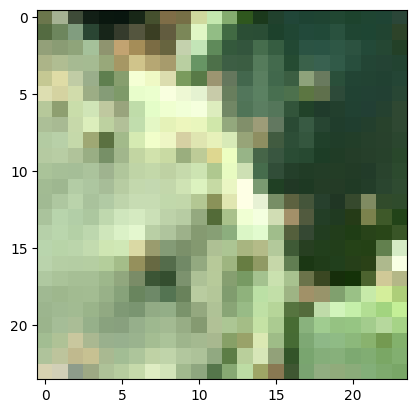

In [6]:
input_img = np.asarray(Image.open('./test_image/test_image1_low.png'))
plt.imshow(input_img)
input_img = input_img[:, :, :3] 
input_img.shape

(96, 96, 3)

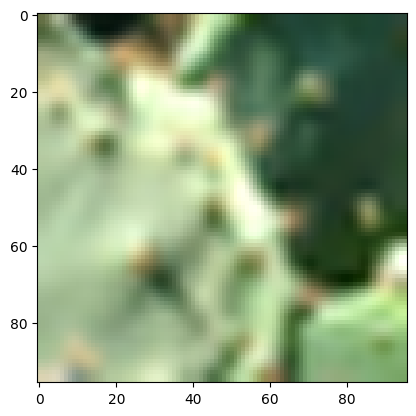

In [7]:
bicubic_img = cv2.resize(input_img,(96,96), interpolation=cv2.INTER_CUBIC)
plt.imshow(bicubic_img)
bicubic_img.shape

In [9]:
high_resolution_img = np.asarray(Image.open('./test_image/test_image1_high.png'))
high_resolution_img = high_resolution_img[:, :, :3] 
high_resolution_img.shape

(96, 96, 3)

In [10]:
edsr_model = keras.models.load_model('./checkpoint/EDSR_epoch500_2024-05-14_19-00.h5',custom_objects={'EDSRModel': EDSRModel, 'PSNR': PSNR})

In [11]:
edsr_predict = edsr_model.predict(input_img)

(96, 96, 3)

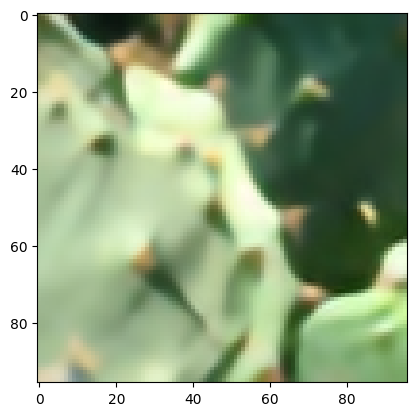

In [12]:
plt.imshow(edsr_predict)
edsr_predict.shape

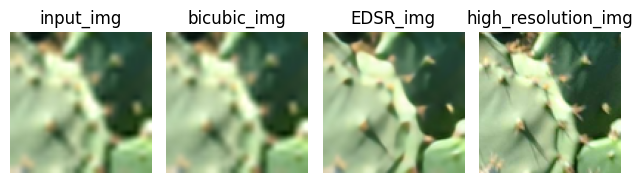

In [13]:
# 1행 2열의 서브플롯을 생성.
fig, axes = plt.subplots(1, 4)

# 첫 번째 서브플롯에 이미지를 표시.
axes[0].imshow(bicubic_img)
axes[0].set_title('input_img')

# 두 번째 서브플롯에 이미지를 표시.
axes[1].imshow(bicubic_img)
axes[1].set_title('bicubic_img')

# 두 번째 서브플롯에 이미지를 표시.
axes[2].imshow(edsr_predict)
axes[2].set_title('EDSR_img')

# 세 번째 서브플롯에 이미지를 표시.
axes[3].imshow(high_resolution_img)
axes[3].set_title('high_resolution_img')

# 각 이미지의 축을 숨김.
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[3].axis('off')

# 서브플롯 간 간격을 조절합니다.
plt.tight_layout()

# 이미지를 표시합니다.
plt.show()

In [69]:
edsr_predict.shape

(96, 96, 3)

In [17]:
print(psnr2(high_resolution_img,bicubic_img))
print(psnr2(high_resolution_img,edsr_predict))

31.202020267487626
32.35636934357605


In [18]:
print(SSIM(high_resolution_img,bicubic_img))
print(SSIM(high_resolution_img,edsr_predict))

0.9751432314085072
0.9870328080550612
